In [10]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


[autoreload of utils failed: Traceback (most recent call last):
  File "/home/kayson/anaconda3/envs/communicability/lib/python3.9/site-packages/IPython/extensions/autoreload.py", line 261, in check
    superreload(m, reload, self.old_objects)
  File "/home/kayson/anaconda3/envs/communicability/lib/python3.9/site-packages/IPython/extensions/autoreload.py", line 459, in superreload
    module = reload(module)
  File "/home/kayson/anaconda3/envs/communicability/lib/python3.9/importlib/__init__.py", line 169, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 613, in _exec
  File "<frozen importlib._bootstrap_external>", line 850, in exec_module
  File "<frozen importlib._bootstrap>", line 228, in _call_with_frames_removed
  File "/home/kayson/ownCloud/communication-and-causation/utils.py", line 119, in <module>
    model: Callable = simple_dynamical_system,
NameError: name 'simple_dynamical_system' is not defined
]


In [11]:
import numpy as np
from msapy import plottings as pl
import matplotlib.pyplot as plt
import scipy.io

import seaborn as sns
import utils as ut
import warnings
from tqdm import tqdm
from sklearn.model_selection import ParameterGrid


In [12]:
SEED = 2023
pl.set_style(font_size=8)
CM = 1/2.54

DEEP_BLUE = '#006685'
BLUE = '#3FA5C4'
WHITE = '#FFFFFF'
HALF_BLACK = '#232324'
ORANGE = '#E84653'
RED= '#BF003F'

PURPLE = '#A6587C'
PURPLER = '#591154'
PURPLEST = '#260126'
NIGHT_BLUE = '#394D73'
YELLOW = '#E6B213'


from_white = [DEEP_BLUE, BLUE, WHITE, ORANGE, RED]
white_to_reds = [WHITE, ORANGE, RED]
white_to_blues = [WHITE, BLUE, DEEP_BLUE]

black_to_reds = [HALF_BLACK, ORANGE, RED]
black_to_blues = [HALF_BLACK, BLUE, DEEP_BLUE]

from_black = [DEEP_BLUE,BLUE,HALF_BLACK,ORANGE,RED]



diverge_from_white = sns.blend_palette(from_white,as_cmap=True)
diverge_from_black = sns.blend_palette(from_black,as_cmap=True)

white_red_mono = sns.blend_palette(white_to_reds,as_cmap=True)
white_blue_mono = sns.blend_palette(white_to_blues,as_cmap=True)

black_red_mono = sns.blend_palette(black_to_reds,as_cmap=True)
black_blue_mono = sns.blend_palette(black_to_blues,as_cmap=True)

purple_red = sns.blend_palette([PURPLEST, PURPLE, RED])

In [30]:
consensus_mat = scipy.io.loadmat('Consensus_Connectomes.mat',simplify_cells=True,squeeze_me=True,chars_as_strings=True)
consensus_mat['LauConsensus']['Readme']

array(['1 - weighted adj mat', '2 - fiber length mat', '3 - fc mat',
       '4 - coordinates', '5{1} - roi name', '5{2} - short name',
       '5{3} - rsn name', '5{4} - hemisphere'], dtype=object)

In [14]:
connectivity = ut.spectral_normalization(1,consensus_mat['LauConsensus']['Matrices'][2][0])
labels = consensus_mat['LauConsensus']['Matrices'][2][4][:,0]
human_fc = consensus_mat['LauConsensus']['Matrices'][2][2]
np.fill_diagonal(human_fc,0)

In [15]:
warnings.filterwarnings("ignore")
n_nodes = connectivity.shape[0]
rng = np.random.default_rng(seed=SEED)
delta = 0.01
tau = 0.02

G =0.74 #this is the optimal value based on the search below
duration = 1000
noise_strength = 0.05

noise = np.zeros((n_nodes,int(duration/delta)+1))
for i in range(int(duration/delta)+1):
    noise[:,i] = rng.normal(0,noise_strength,(n_nodes,))

In [16]:
simple_human_dynamics = ut.simulate_dynamical_system_parallel(adjacency_matrix=connectivity,coupling=G,dt=delta,timeconstant=tau,input_matrix=noise,duration=duration)

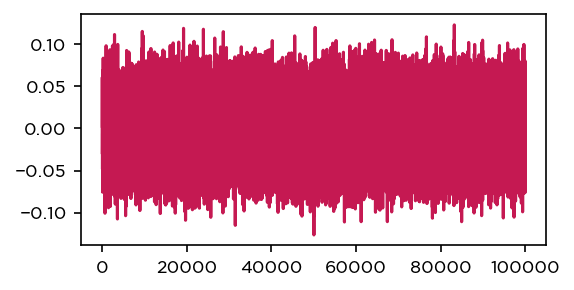

In [17]:
plt.figure(figsize=(4,2),dpi=150)
plt.plot(simple_human_dynamics[10],alpha=0.9,color=RED);
fc = np.corrcoef(simple_human_dynamics)
np.fill_diagonal(fc,0)
fc = np.nan_to_num(fc)

0.23416942950163153

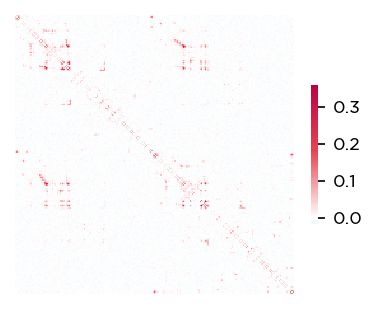

In [18]:
plt.figure(figsize=(3,3),dpi=150)
sns.heatmap(fc,square=True,center=0,cmap=diverge_from_white,cbar_kws={"shrink":.4},linewidths=0.,yticklabels=False,xticklabels=False);
np.corrcoef(human_fc[np.triu_indices_from(human_fc, k=1)], fc[np.triu_indices_from(fc, k=1)])[0, 1]

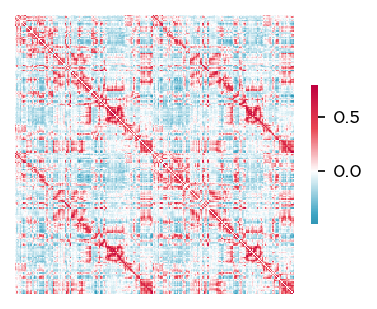

In [19]:
plt.figure(figsize=(3,3),dpi=150)
sns.heatmap(human_fc,square=True,center=0,cmap=diverge_from_white,cbar_kws={"shrink":.4},linewidths=0.,yticklabels=False,xticklabels=False);

In [20]:
parameter_space = list(ParameterGrid({'G':np.linspace(0.01,1.,20).round(2,)}))

In [21]:
for parameters in tqdm(parameter_space,
                       total=len(parameter_space),
                       desc='Optimizing hyperparams: '):
    dynamics = ut.simulate_dynamical_system_parallel(adjacency_matrix=connectivity,
                                    coupling=parameters['G'],
                                    dt=delta,
                                    timeconstant=tau,
                                    input_matrix=noise,
                                    duration=duration)
    
    fc = np.corrcoef(dynamics)
    np.fill_diagonal(fc,0)
    fc = np.nan_to_num(fc)
    if fc.mean() > 0.9:
        parameters.update({'correlation': 0})
    else:
        r = np.corrcoef(human_fc[np.triu_indices_from(human_fc, k=1)], fc[np.triu_indices_from(fc, k=1)])[0, 1]
        parameters.update({'correlation': r})


Optimizing hyperparams: 100%|██████████| 20/20 [03:50<00:00, 11.52s/it]


In [22]:
optimum_params = max(parameter_space, key=lambda x: x['correlation'])
dynamics = ut.simulate_dynamical_system_parallel(adjacency_matrix=connectivity,
                                    coupling=optimum_params['G'],
                                    dt=delta,
                                    timescale=tau,
                                    input_matrix=noise,
                                    duration=duration)
fc = np.corrcoef(dynamics)
np.fill_diagonal(fc,0)
optimum_params

{'G': 0.74, 'correlation': 0.23416942950163153}

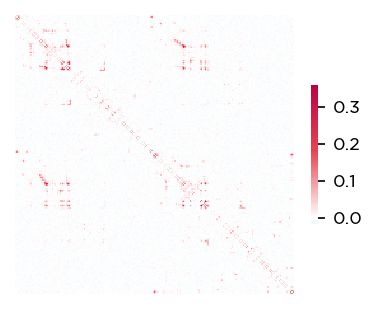

In [23]:
plt.figure(figsize=(3,3),dpi=150)
sns.heatmap(fc,square=True,center=0,cmap=diverge_from_white,cbar_kws={"shrink":.4},linewidths=0.,yticklabels=False,xticklabels=False);

In [24]:
fit_results = []
for index,correlation in enumerate(parameter_space):
    fit_results.append(parameter_space[index]['correlation'])

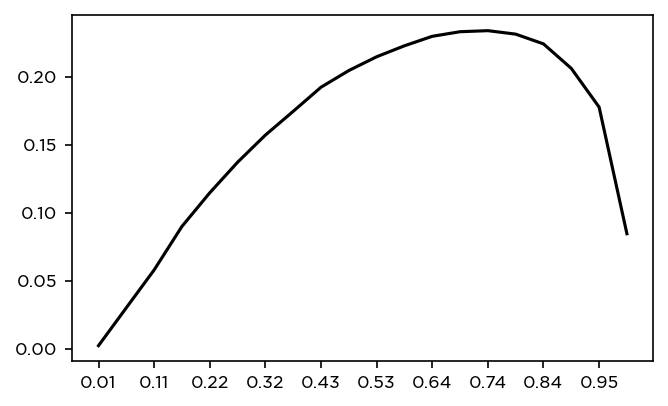

In [28]:
plt.figure(figsize=(5,3),dpi=150)
plt.plot(fit_results,color='k')
plt.xticks(np.arange(0,20,2),np.linspace(0.01,1.,20).round(2,)[::2]);